In [1]:
import torch
from kan import KAN
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Import PySpark modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.sql.types import DoubleType, StructType, StructField, StringType, IntegerType

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
spark = SparkSession.builder \
    .appName("KAN_BigData_Preparation") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("SparkSession created successfully!")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/06/01 12:15:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
SparkSession created successfully!


In [3]:
spark_df = spark.read.csv('data/processed_country_data.csv', header=True, inferSchema=True)

In [4]:
print("Schema của Spark DataFrame:")
spark_df.printSchema()

Schema của Spark DataFrame:
root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- new_cases: double (nullable = true)
 |-- new_deaths: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- population_density: double (nullable = true)
 |-- median_age: double (nullable = true)
 |-- aged_65_older: double (nullable = true)
 |-- aged_70_older: double (nullable = true)
 |-- gdp_per_capita: double (nullable = true)
 |-- cardiovasc_death_rate: double (nullable = true)
 |-- diabetes_prevalence: double (nullable = true)
 |-- life_expectancy: double (nullable = true)
 |

In [5]:
# --- Lọc dữ liệu với PySpark ---
countries_near_vietnam = [
    'Vietnam', 'Thailand', 'Laos', 'Cambodia', 'China', 'Malaysia',
    'Singapore', 'Indonesia', 'Philippines', 'Brunei', 'South Korea', 'Japan'
]

# Lọc theo 'continent' và 'location'
spark_df = spark_df.filter((col('continent') == 'Asia') & (col('location').isin(countries_near_vietnam)))

# --- Chọn các đặc trưng (features) ---
selected_features = [
    'new_cases_smoothed_lag_5', 'new_cases_smoothed_lag_3', 'new_cases_smoothed_lag_1',
    'new_cases_smoothed_lag_4', 'new_cases_smoothed_lag_2',
    'new_deaths_smoothed_lag_5', 'new_deaths_smoothed_lag_3',
    'new_deaths_smoothed_lag_1', 'total_deaths_lag_5', 'total_deaths_lag_3',
    'total_deaths_lag_1', 'population', 'new_deaths_smoothed_lag_4',
    'new_deaths_smoothed_lag_2'
]
target_feature = 'new_cases_next_day'

# Chọn các cột cần thiết
spark_df_selected = spark_df.select(selected_features + [target_feature])

# Loại bỏ các hàng có giá trị NaN trong các cột đã chọn
spark_df_selected = spark_df_selected.na.drop()

In [6]:
# --- Chuyển Spark DataFrame về Pandas DataFrame để huấn luyện KAN ---
# Đây là bước quan trọng: thu thập dữ liệu từ cluster về driver node.
# Cần đảm bảo dữ liệu đã được xử lý đủ nhỏ để fit vào bộ nhớ của driver node.
print("Collecting data from Spark DataFrame to Pandas DataFrame...")
df = spark_df_selected.toPandas()
print(f"Collected {len(df)} rows for KAN training.")

Collected 20027 rows for KAN training.


In [7]:
# --- Chuẩn bị dữ liệu cho KAN (tiếp theo mã của bạn) ---
X = df[selected_features]
y = df[[target_feature]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 1. Chuẩn hóa Input (X_train, X_test) ---
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# --- 2. Chuẩn hóa Label (y_train, y_test) ---
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [8]:
# Chuyển đổi sang Tensor PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float64).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float64).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float64).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float64).to(device)

In [9]:
dataset = {}
dataset['train_input'] = X_train_tensor
dataset['test_input'] = X_test_tensor
dataset['train_label'] = y_train_tensor
dataset['test_label'] = y_test_tensor

checkpoint directory created: ./model
saving model version 0.0
Initial KAN plot:


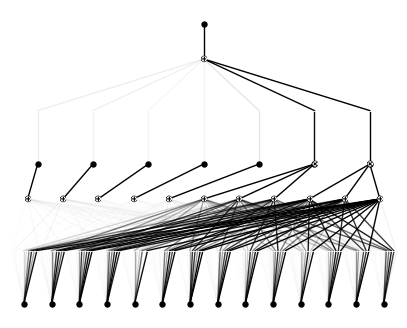

In [10]:
steps = 100
grid = 3

model = KAN(width=[dataset['train_input'].shape[1],[5,2], 1], mult_arity=3, base_fun='identity', grid=grid, device=device)
model.get_act(dataset)
print("Initial KAN plot:")
model.plot()

In [11]:
print("Fitting KAN model (first pass)...")
results = model.fit(dataset, steps=steps, opt='LBFGS', lamb=0.05, lamb_coef=1.0)

Fitting KAN model (first pass)...


| train_loss: 9.60e-01 | test_loss: 3.52e-01 | reg: 6.90e+02 | : 100%|█| 100/100 [01:36<00:00,  1.04

saving model version 0.1


In [13]:
train_losses = []
test_losses = []
train_losses += results['train_loss']
test_losses += results['test_loss']

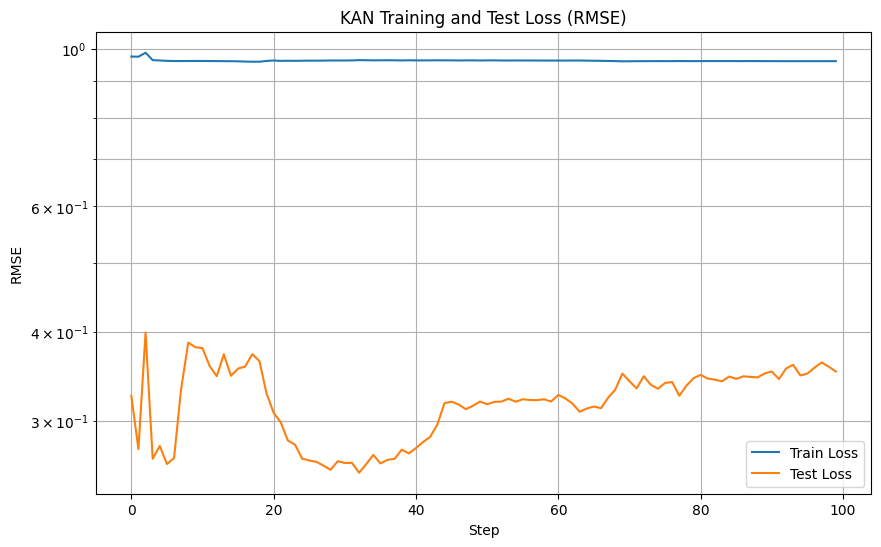

In [14]:
# --- Vẽ biểu đồ mất mát ---
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Step')
plt.yscale('log')
plt.title('KAN Training and Test Loss (RMSE)')
plt.grid(True, which="both", ls="-")
plt.show()

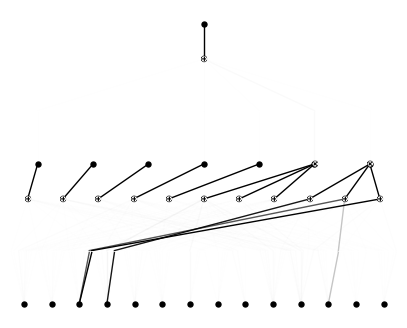

In [15]:
model.plot(metric='forward_n')

In [19]:
results

{'train_loss': [array(0.97453193),
  array(0.9740551),
  array(0.9866704),
  array(0.96328178),
  array(0.96215305),
  array(0.96114836),
  array(0.96055866),
  array(0.96035756),
  array(0.96059526),
  array(0.96068657),
  array(0.96068714),
  array(0.96048195),
  array(0.96027076),
  array(0.96007321),
  array(0.95991972),
  array(0.95968427),
  array(0.95885337),
  array(0.95836327),
  array(0.95836719),
  array(0.96067456),
  array(0.96217291),
  array(0.96093945),
  array(0.96136914),
  array(0.96112747),
  array(0.96147583),
  array(0.96165016),
  array(0.96170654),
  array(0.96181727),
  array(0.96221652),
  array(0.9621312),
  array(0.96218554),
  array(0.96244402),
  array(0.96326754),
  array(0.96301313),
  array(0.96257521),
  array(0.96283721),
  array(0.96288346),
  array(0.96273113),
  array(0.9623224),
  array(0.96272944),
  array(0.96251173),
  array(0.96238232),
  array(0.96252863),
  array(0.96281991),
  array(0.9625849),
  array(0.96254408),
  array(0.96224755),
  ar

In [16]:
model.feature_score

tensor([0.0051, 0.0074, 1.9989, 1.0050, 0.0082, 0.0060, 0.0102, 0.0104, 0.0036,
        0.0127, 0.0149, 0.2832, 0.0071, 0.0118], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [17]:
spark.stop()